In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, functional
import torch.optim as optim
from torch.utils.data import Dataset, dataloader
from torchsummary import summary

import sys
sys.path.append('../src')
from model import *
from datagen import *

c:\Users\matti\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Dataclass for adding problem

class Datamodel(Dataset):
    def __init__(self,time_pos_points,labels):
        self.x = time_pos_points
        self.y = labels
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

## Creating dataset for first problem

First problem is seeing how the RNN trains to just add a list of numbers in time together

In [3]:
n_data = 1000
t_steps = 10

data,labels = datagen_full_sum_normal(n_data,t_steps,normalize=True)
# data,labels = datagen_timewise_labels(n_data,t_steps,2)
# print(data[1],labels[1])

BATCH_SIZE = 16

training_data = Datamodel(data,labels)
training_loader = torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

data.shape

print(data[100].sum())

tensor(1.)


### Training first non-regualrized model

In [4]:
hidden_size = 1
input_size = 1
output_size = 1

train1 = False

# Run multiple times to see the effect of the random initialization
if train1:
    model = torch_RNN1(input_size,t_steps,output_size,hidden_size,lr=0.001,irnn=False)
    _ = model.train(training_loader,epochs=100)
    model.plot_losses(average=30)
    # model.plot_accs()
    print(f"Init weights: Wh = {model.Wh_init}, Wx = {model.Wx_init}")
    print("Guess on the first 15 training data: ",model(data[0:15]))
    print("Weight of the hidden layer Wh: ",model.rnn.weight_hh_l0, " Weight of the input layer Wx: ",model.rnn.weight_ih_l0)

Both our weight matrices are close to 1, which means it counts on a line. Find that if $W_x$ is initialized as a negative number the model will train very little and the weights barely change from the initialized values. This is because of ReLU where if we have a negative input weight we will end up with 0, and with just one hidden dimension the signal will die.

### Multidimensional hidden layer h

Guess on the first 15 training data:  tensor([0.6790, 0.8039, 0.4496, 0.3951, 0.6600, 0.7467, 1.2311, 0.9804, 0.5257,
        0.8561, 0.4768, 1.0772, 0.6844, 0.9610, 0.7386],
       grad_fn=<NormBackward1>)


100%|██████████| 300/300 [00:41<00:00,  7.16it/s]


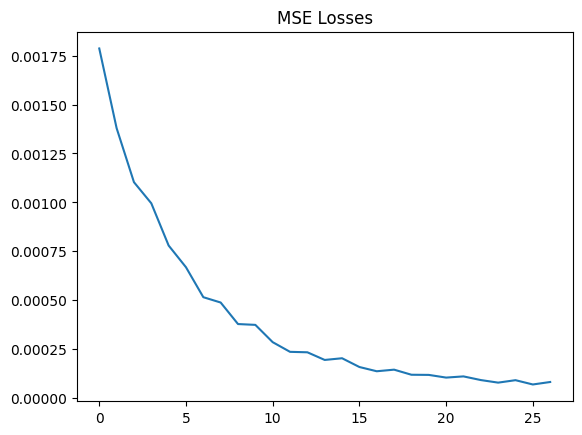

Guess on the first 15 training data:  tensor([0.9986, 0.9991, 1.0019, 1.0087, 0.9990, 0.9998, 1.0196, 1.0060, 1.0014,
        0.9995, 1.0025, 1.0144, 0.9989, 1.0032, 0.9994],
       grad_fn=<NormBackward1>)


In [99]:
hidden_size = 100
input_size = 1
output_size = 1

train2 = True

if train2:
    # model2 = torch_RNN1(input_size,t_steps,output_size,hidden_size,lr=0.01,irnn=True,outputnn=False,Wx_normalize=True)
    model2 = torch_RNN_full_manual(input_size,t_steps,output_size,hidden_size,lr=0.001,irnn=False,outputnn=False,Wx_normalize=False,activation=False)
    print("Guess on the first 15 training data: ", model2(data[0:15]))
    _ = model2.train(training_loader,epochs=300)
    model2.plot_losses(average=30)
    # model2.plot_accs()
    print("Guess on the first 15 training data: ", model2(data[0:15]))
    # print("Weight of the hidden layer: ",model2.rnn.weight_hh_l0, " Weight of the input layer: ",model2.rnn.weight_ih_l0)

In [100]:
# SVD of the weight matrix Wh

Wh = model2.hidden.weight.detach().numpy()
U, s, Vh = np.linalg.svd(Wh)
print("Singular values of Wh: ",s)

np.prod(s)
np.linalg.det(Wh)

Singular values of Wh:  [1.4597653  1.3503163  1.3047086  1.2838438  1.2243294  1.1916188
 1.162559   1.1112705  1.0768144  1.0594465  1.0461125  1.0191576
 0.9999403  0.9904424  0.9673818  0.95353734 0.9329977  0.9165715
 0.8979343  0.8811746  0.8732081  0.8527937  0.84939563 0.8308079
 0.8253569  0.8134433  0.7906467  0.77541345 0.7671589  0.75244534
 0.72974056 0.7260875  0.70635283 0.6978109  0.6868917  0.68089026
 0.6592935  0.6534682  0.6391947  0.62800103 0.62581825 0.61458385
 0.60186327 0.58573794 0.580691   0.573236   0.55682075 0.54332
 0.5340872  0.5258174  0.5000313  0.49517253 0.47668228 0.46979374
 0.4628292  0.4565122  0.44138804 0.43158126 0.42070663 0.41451108
 0.41236266 0.40121368 0.39744878 0.3786005  0.36593553 0.36258093
 0.33839408 0.3294559  0.320667   0.31497383 0.3121869  0.30250156
 0.28954053 0.28245187 0.2787212  0.24967071 0.23983122 0.2283582
 0.22428231 0.21673225 0.20832475 0.19285153 0.18802926 0.1779791
 0.16448466 0.14816064 0.13421565 0.11944351 0.

-4.553e-42

Ser at $det(W_h)\approx 0$, men at singulærverdiene er ganske lineært avtagende fra litt over 1 til nesten 0.

Norm av input: 5.388476346690755
Norm av Wh-skalert input 3.3271577687917455 ratio: 0.6174579889981452


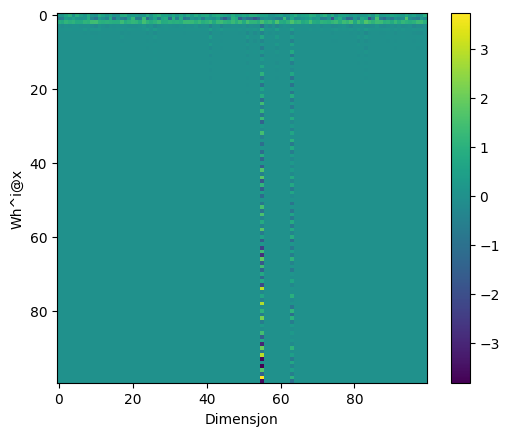

In [181]:
# Sjekker om Wh beholder normen til x 
x = np.random.uniform(size=100)
# x_const = np.ones((100,100))
x_const = np.random.uniform(size=(100,100))
print("Norm av input:", np.linalg.norm(x))
print("Norm av Wh-skalert input",np.linalg.norm(Wh @ x), "ratio:", np.linalg.norm(Wh @ x)/np.linalg.norm(x))
# Finner utviklingen av normen av Wh-skalert input
for i in range(1,100):
    x_const[i] = np.linalg.norm(model2.input.weight.detach().numpy())**i* Wh**i @ x_const[i]
plt.imshow(x_const)
# pcm = plt.pcolor(x_const, norm = "log")
# plt.colorbar(pcm)
plt.colorbar()
plt.xlabel("Dimensjon")
plt.ylabel("Wh^i@x")
plt.show()

Ser at $W_h$ nedskalerer inputet, men at den teller langs én dominant dimensjon i inputet.

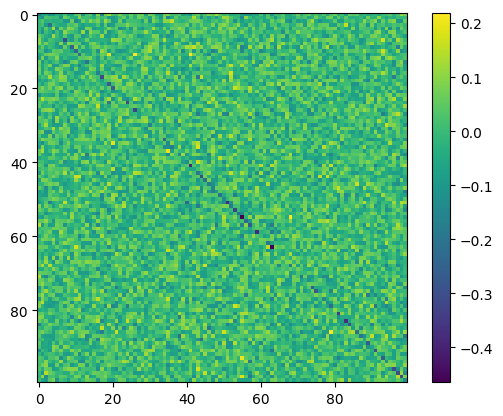

In [114]:
plt.imshow(Wh)
plt.colorbar()

Ser at $W_h$ har en relativt tydelig diagonal med spesielt negative verdier.

In [124]:
import numpy as np
from sklearn.decomposition import PCA

# PCA of the weight matrix Wh

pca = PCA(n_components=2)
pca.fit(Wh)
print("PCA variance ratio: ",pca.explained_variance_ratio_) # Variance explained by each component, the bigger the more a dimension is important
print("PCA singular values: ",pca.singular_values_)
# print("PCA components: ",pca.components_)
# print("PCA mean: ",pca.mean_)
print("PCA noise: ", pca.noise_variance_)

# covariance = pca.get_covariance()

# # Plot the covariance matrix

# plt.imshow(covariance, cmap='hot', interpolation='nearest')
# plt.colorbar()
# plt.show()

# Wh_pca = pca.transform(Wh)

# # SVD of Wh_pca

# U, s, Vh = np.linalg.svd(Wh_pca)
# print("Singular values of Wh_pca: ",s)

# # PCA of randomly initialized weight matrix Wh

# pca = PCA(n_components=2)
# pca.fit(model2.Wh_init)
# print("PCA singular values: ",pca.singular_values_)

# plt.imshow(pca.get_covariance(), cmap='hot', interpolation='nearest')

PCA variance ratio:  [0.04957098 0.04223813]
PCA singular values:  [1.4588808 1.3466612]
PCA noise:  0.004019092


Checking if model counts linearly

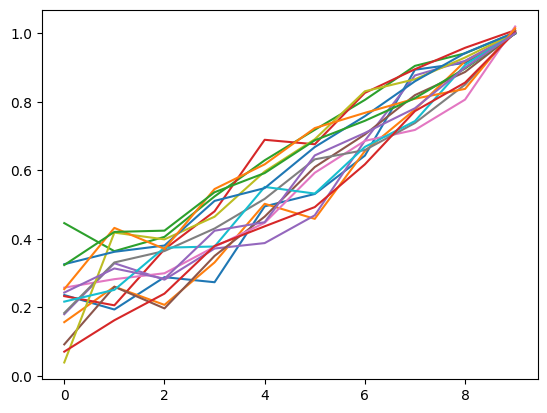

In [169]:
# model2.hts_last.shape
# model2.hts_last.norm(dim=2).shape
# htss = model2.hts_last.norm(dim=2)
model2.hts.norm(dim=2).shape
htss = model2.hts.norm(dim=2)
plt.plot(htss.detach().numpy())
plt.show()

Ser tydelig at det er en lineær telling med normen av hidden states $h_t$ fra nærmere 0 til 1.

In [168]:
# Norm of Wx

# Wx = model2.rnn.weight_ih_l0.detach().numpy()
Wx = model2.input.weight.detach().numpy()
print("Norm of Wx: ",np.linalg.norm(Wx))

Norm of Wx:  2.1883225


Find that the model counts linearly with $h_t$ up to 1. It manages this even though $|W_x|\approx2$ and $|W_h h|/|h|\approx 0.6$. We saw above that $W_h$ scales $h$ such that it increases in one dominant dimension. All this shows that an unregularized RNN will count linearly (på en tallinje) to solve the adding problem.